# 01 PyTorch Workflow
- Resource Notebook: - https://www.learnpytorch.io/01_pytorch_workflow/
1. Preparing and loading data.
2. Building a model.
3. Training the model.
4. Making predictions.
5. Saving and loading the model.

## 0. Importing Dependencies

In [1]:
import torch
import numpy
from torch import nn
import matplotlib.pyplot as plt

## 1. ETL of Data

### Using straight line equation ( y = m*x + b) to create a dataset.

In [2]:
weight = 0.9  #m
bias = 0.4      #b

start = 0
end = 1
step = 0.05
X = torch.arange(start, end, step).unsqueeze(dim=1) #Inputs
y = weight * X + bias #Labels or outputs

X[:5], y[:5], 

(tensor([[0.0000],
         [0.0500],
         [0.1000],
         [0.1500],
         [0.2000]]),
 tensor([[0.4000],
         [0.4450],
         [0.4900],
         [0.5350],
         [0.5800]]))

In [3]:
len(X), len(y)

(20, 20)

### Splitting data

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
def plot_preds(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    '''
    Function that plots the data and prediction
    '''
    plt.figure(figsize=(16,8))
    plt.scatter(train_data, train_labels, c='b', label="Training Data")
    plt.scatter(test_data, test_labels, c='r', label = "Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='g', label='Predictions')
    plt.legend()
    plt.show()

## 2. Building a model

In [6]:
class LinearRegression(nn.Module):  # <- Everything in pytorch inherits from nn.module
    '''
    Class that implements the Linear Regression Model
    '''
    def __init__(self):
        super().__init__()
        #Random initalization of parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    #Forward Prop
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias #Straight line equation

In [7]:
#Setting a random seed.
torch.manual_seed(42)

#Instance of our model
model_0 = LinearRegression() 

#Checking params
for i in model_0.parameters(): # <- .parameters() returns a generator object
    print(i)

Parameter containing:
tensor([0.3367], requires_grad=True)
Parameter containing:
tensor([0.1288], requires_grad=True)


In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
#Making predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4150],
        [0.4318],
        [0.4487]])

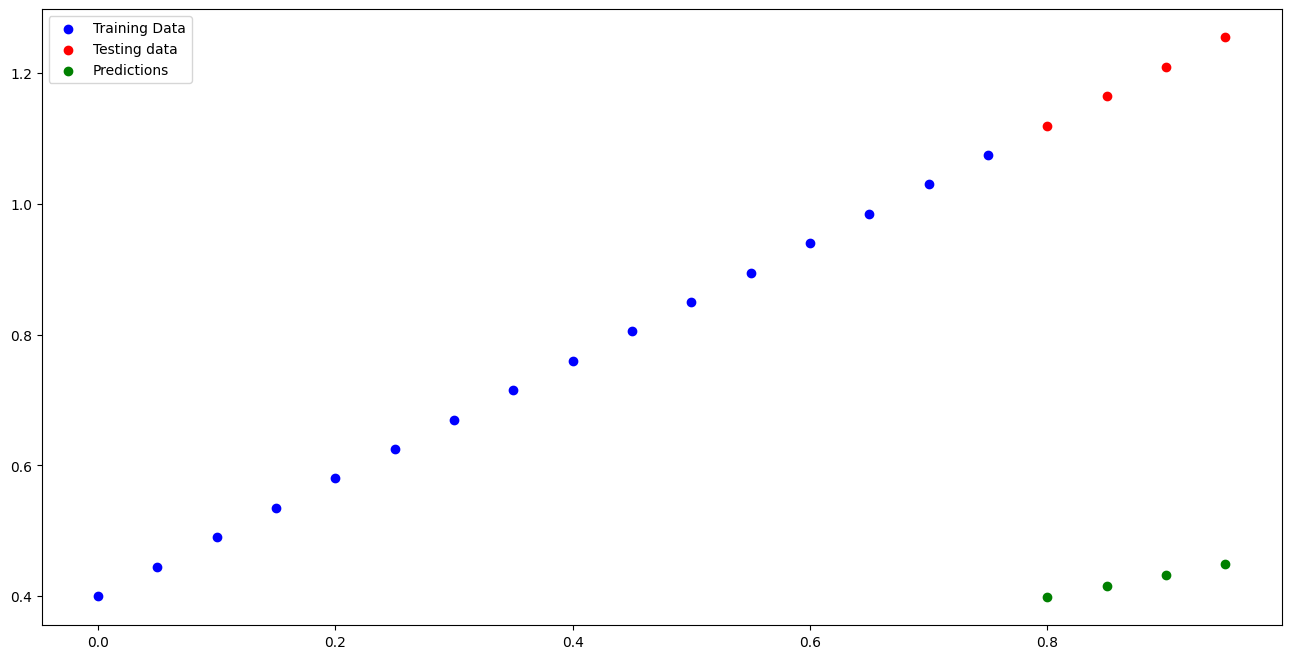

In [10]:
plot_preds(predictions=y_preds)

In [11]:
#Cost function
loss_fn = nn.L1Loss() # <- Mean Absolute Error

#Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # <- Stochastic Gradient Descent


## 3. Training and Testing Loop

In [12]:
epochs = 300

epoch_count = []
train_loss_val = []
test_loss_val = []

for epoch in range(epochs):
    model_0.train() #Training mode

    #Forward pass
    y_pred = model_0(X_train)

    #Cost function computation
    loss = loss_fn(y_pred, y_train)

    #Optimizer
    optimizer.zero_grad()

    #Backprop
    loss.backward()

    #Progressing the optimizer
    optimizer.step()

    #Testing
    model_0.eval()  #Turns off he gradient tracking to save memory and speed up the training process

    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch%20 == 0:
        epoch_count.append(epoch)
        train_loss_val.append(loss.detach().numpy()) # <- As these are all tensors, we need to convert them to numpy array
        test_loss_val.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.48243170976638794 | Test Loss: 0.7508052587509155
Epoch: 20 | Loss: 0.25430673360824585 | Test Loss: 0.4851803183555603
Epoch: 40 | Loss: 0.09702769666910172 | Test Loss: 0.26957109570503235
Epoch: 60 | Loss: 0.07244949042797089 | Test Loss: 0.18640698492527008
Epoch: 80 | Loss: 0.06444959342479706 | Test Loss: 0.15140749514102936
Epoch: 100 | Loss: 0.0575496144592762 | Test Loss: 0.13497039675712585
Epoch: 120 | Loss: 0.05065082758665085 | Test Loss: 0.12022078037261963
Epoch: 140 | Loss: 0.04375709593296051 | Test Loss: 0.10378336906433105
Epoch: 160 | Loss: 0.036863360553979874 | Test Loss: 0.08734598755836487
Epoch: 180 | Loss: 0.029969632625579834 | Test Loss: 0.0709085464477539
Epoch: 200 | Loss: 0.023075899109244347 | Test Loss: 0.05447113513946533
Epoch: 220 | Loss: 0.016182171180844307 | Test Loss: 0.03803369402885437
Epoch: 240 | Loss: 0.009288441389799118 | Test Loss: 0.021596282720565796
Epoch: 260 | Loss: 0.0023947153240442276 | Test Loss: 0.005158871412

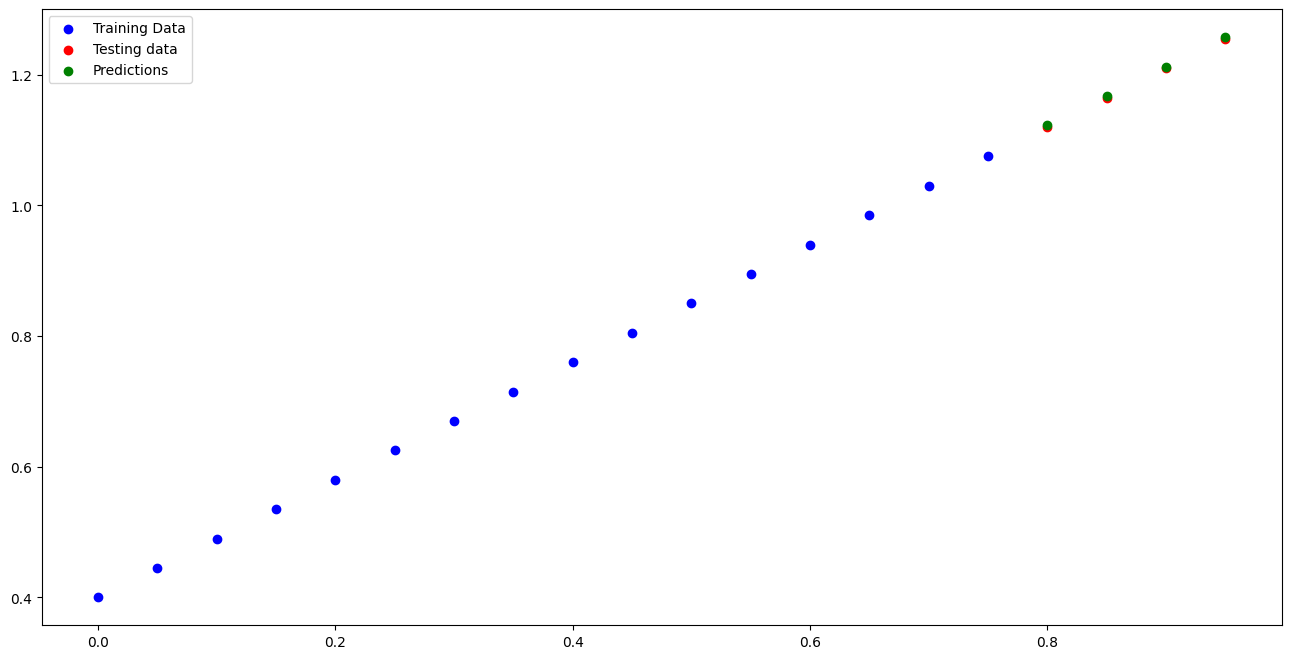

In [13]:
plot_preds(predictions=test_pred)

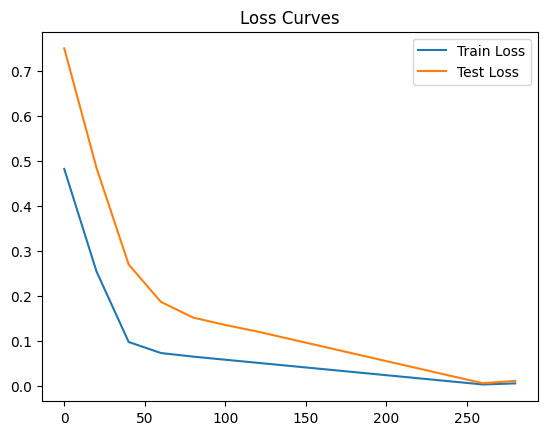

In [14]:
plt.plot(epoch_count, train_loss_val, label="Train Loss")
plt.plot(epoch_count, test_loss_val, label='Test Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

## 4. Saving a model
- `torch.save()`: - allows to save a PyTorch object in pickle format.
- `torch.load()`: - allows to load the PyTorch object.
- `torch.nn.Module.load_state_dict()`: - allows to load a model's saved state dictionary.

In [15]:
from pathlib import Path

#Creating model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#Creating model save path
MODEL_NAME = "01_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Saving the state dictionary
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_model_0.pth


In [16]:
new_model = LinearRegression()

#UPdating instance with out loaded params.
new_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

new_model.state_dict()

OrderedDict([('weights', tensor([0.8961])), ('bias', tensor([0.4063]))])

## 5. Putting it all together
- Get data ready by turning them into tensors.
- Build or pick a pre-trained model.
- Fit the model and make predictions.
- Evaluate the model.
- Improve through experimentation.
- Save and load your model.

In [17]:
weight = 0.7
bias = 0.4

start = 0
end = 2
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.4000],
         [0.4140],
         [0.4280],
         [0.4420],
         [0.4560]]))

In [18]:
#Splitting the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

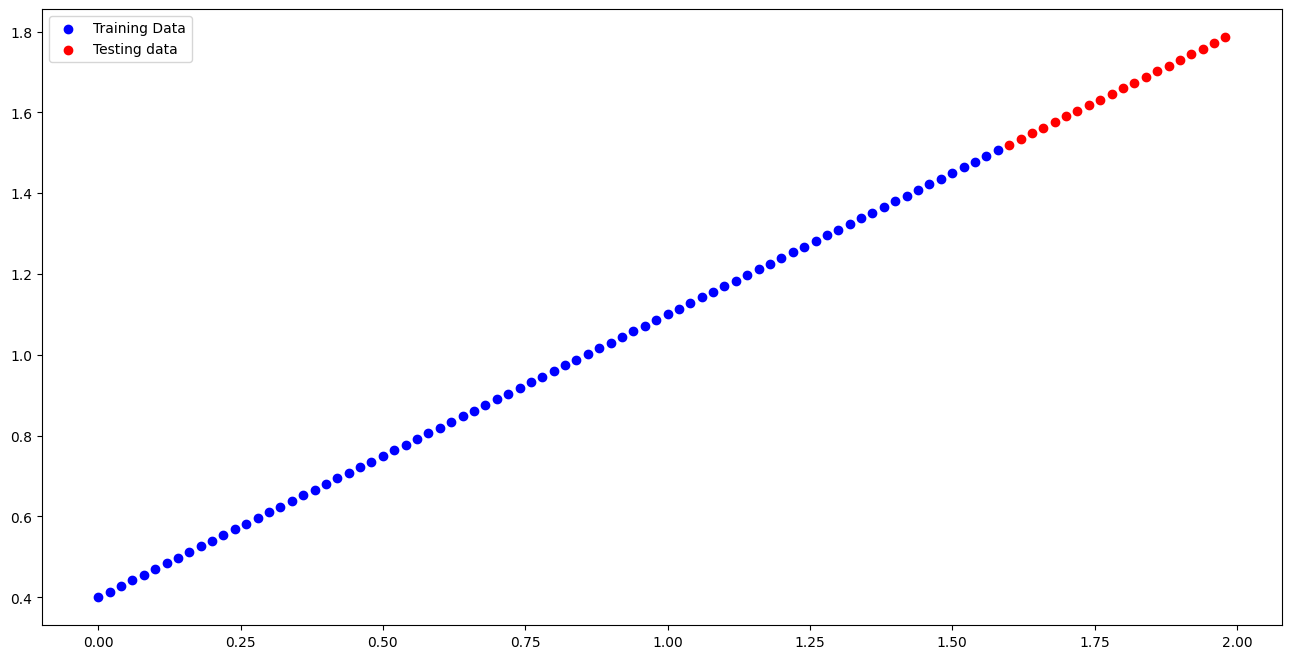

In [19]:
plot_preds(X_train, y_train, X_test, y_test)

In [20]:
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        #Using nn.Linear() instead of manually initializing params.
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 <bound method Module.state_dict of LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 )>)

In [21]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [22]:
#Training Loop
torch.manual_seed(42)

epochs = 260

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_preds = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_preds, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.4809933304786682 | Test loss: 0.5213909149169922
Epoch: 20 | Train loss: 0.15617355704307556 | Test loss: 0.03857112675905228
Epoch: 40 | Train loss: 0.05341501906514168 | Test loss: 0.10145683586597443
Epoch: 60 | Train loss: 0.03519464284181595 | Test loss: 0.06802394241094589
Epoch: 80 | Train loss: 0.017009036615490913 | Test loss: 0.03187239170074463
Epoch: 100 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 120 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 140 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 160 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 180 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 200 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 220 | Train loss: 0.006804469041526318 | Test loss: 0.01601201854646206
Epoch: 240 | Train loss: 0.006804469041526318 | Test loss: 0.016

In [23]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7013]])),
             ('linear_layer.bias', tensor([0.4058]))])

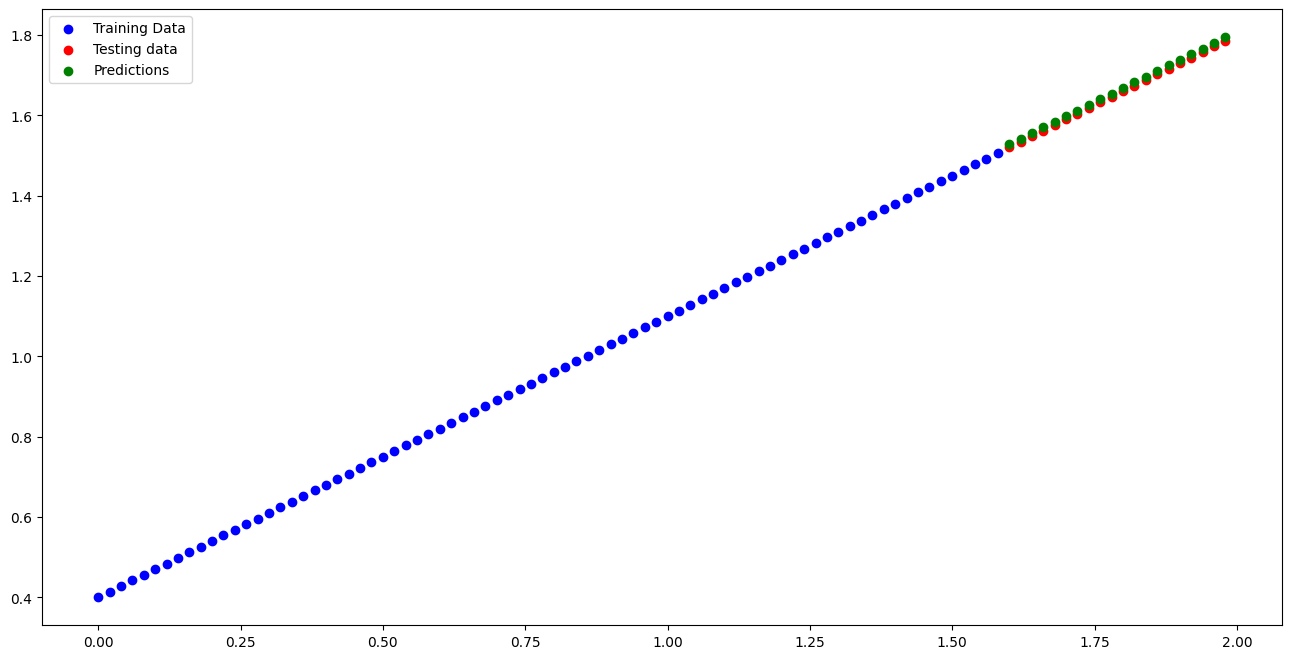

In [27]:
model_1.eval()

#Predictions
with torch.inference_mode():
    y_preds2 = model_1(X_test)

plot_preds(X_train, y_train, X_test, y_test, y_preds2)

In [28]:
#Saving the model
from pathlib import Path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [29]:
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving the model to: models/01_model_1.pth
